# Exploring how genome size (Cvalue) is affected by variety of features. 

- 01: Data cleaning
- 02a: ML exploration for Cvalue predictors
- **02b: ML exploration for No_bugs predictors**
- 04: build a new phylogeny
- 03a: PGLS phylogenetic controlled comparison for CVal
- 03b: PGLS phylogenetic controlled comparison for No_bugs

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
# Load your data
df = pd.read_csv('./data/cleaned_20240729')

In [2]:
df

,plant_no,long_val,soil_nutr_val,leafP_val,leafN_val,clonality_state,dicliny_val,plant_name,genus,family,Cval,No_bugs
0,260070070,100.0,0.0,1.0,10.0,1,3.0,PINUS SYLVESTRIS,PINUS,PINACEAE,NaN,65.0
1,280050020,100.0,0.0,1.0,10.0,1,1.0,JUNIPERUS COMMUNIS,JUNIPERUS,CUPRESSACEAE,NaN,16.0
2,290010010,500.0,3.0,1.0,10.0,1,1.0,TAXUS BACCATA,TAXUS,TAXACEAE,NaN,25.0
3,310010590,NaN,1.0,NaN,NaN,1,1.0,SALIX LAPPONUM,SALIX,SALICACEAE,NaN,3.0
4,310020020,NaN,NaN,NaN,NaN,0,1.0,POPULUS X CANESCENS,POPULUS,SALICACEAE,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1731,2030240140,NaN,NaN,NaN,NaN,1,4.0,ORCHIS PURPUREA,ORCHIS,ORCHIDACEAE,NaN,NaN
1732,2030240180,NaN,NaN,NaN,NaN,1,4.0,ORCHIS MASCULA,ORCHIS,ORCHIDACEAE,NaN,NaN
1733,2030300010,NaN,NaN,NaN,NaN,1,4.0,OPHRYS INSECTIFERA,OPHRYS,ORCHIDACEAE,NaN,NaN
1734,2030300160,NaN,NaN,NaN,NaN,1,4.0,OPHRYS FUCIFLORA,OPHRYS,ORCHIDACEAE,NaN,NaN


In [21]:
# make model and fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

# note, some columns are not useful. 
print(df.columns)

Index(['plant_no', 'long_val', 'soil_nutr_val', 'leafP_val', 'leafN_val',
       'clonality_state', 'dicliny_val', 'plant_name', 'genus', 'family',
       'Cval', 'No_bugs', 'log_long_val'],
      dtype='object')


In [22]:
df['log_long_val'] = np.log(df['long_val'])

In [23]:
# Create a boolean masks where the Cval and No_bugs is not NaN
mask_c = ~pd.isna(df['Cval'])
mask_b = ~pd.isna(df['No_bugs'])

# Apply the mask to the DataFrame to keep corresponding rows
df_c = df[mask_c]
df_b = df[mask_b]

Model the cvalue according to following variables: long_val, soil_nutr_val, leafP_val, leafN_val, clonality_state, dicliny_val, genus, family.

In [13]:
print(f'There are {df_c.shape[0]} cases for which we have Cvalue')


There are 109 cases for which we have Cvalue


In [14]:
print(f'There are {df_b.shape[0]} cases for which we have number of bugs')


There are 870 cases for which we have number of bugs


In [24]:
# fit the model
indepVar = ['leafP_val', 'leafN_val', 'clonality_state', 'dicliny_val', 'soil_nutr_val', 'log_long_val']


## XGBoost of Cvalue

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_c[indepVar], df_c['Cval'], test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Print feature importances
print("Feature Importances:", model.feature_importances_)
print("The features are:", indepVar)


Mean Squared Error: 1104.8023145848072
Feature Importances: [0.04044932 0.10040445 0.28779414 0.15037315 0.3123912  0.10858774]
The features are: ['leafP_val', 'leafN_val', 'clonality_state', 'dicliny_val', 'soil_nutr_val', 'log_long_val']


You are using an XGBoost version below 1.6.0 which is not fully supported by shap. Shap falls back to encoding the model as JSON which can lead to numerical precision issues. Please consider upgrading to XGBoost 1.6.0 or higher.


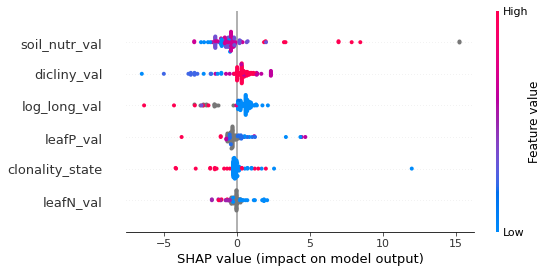

In [25]:
# !pip install shap
import shap
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(df_c[indepVar])
shap.summary_plot(shap_values, df_c[indepVar])

# from sklearn.inspection import plot_partial_dependence
# plot_partial_dependence(model, X_test, indepVar)


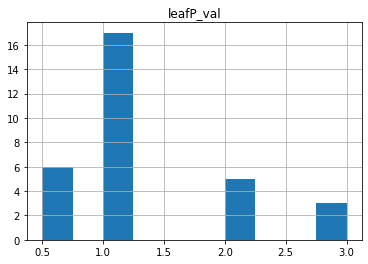

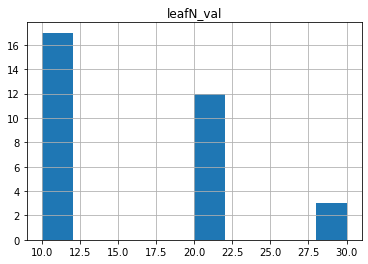

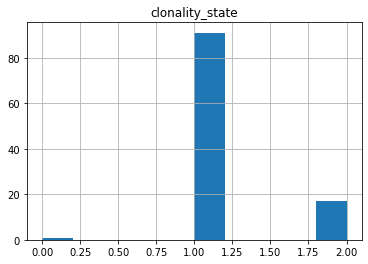

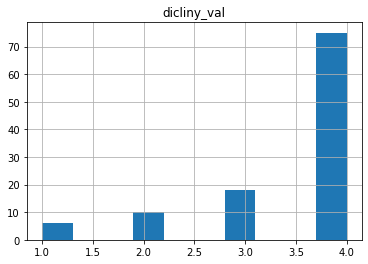

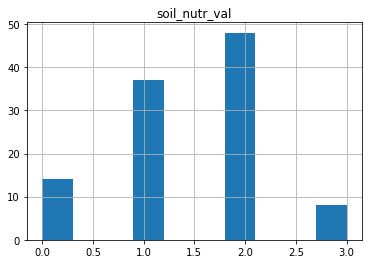

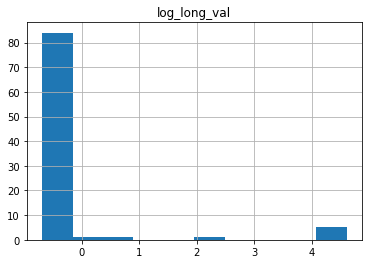

In [26]:
# check for outliers in these both independent vars and y vals
import matplotlib.pyplot as plt
for var in indepVar:
    df_c.hist(var)
    plt.show()

In [27]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# !pip install xgboost

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error


# Create a pipeline with KNN imputer and standard scaler
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),  # You can adjust the number of neighbors
    ('scaler', StandardScaler()),
    ('model', XGBRegressor())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Extract the model from the pipeline
model_n = pipeline.named_steps['model']
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Cross-validation scores
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation MSE:", -scores.mean())


Mean Squared Error: 1088.4434937422338
Cross-validation MSE: 54.99206212513492


In [28]:
# Print feature importances
print("Feature Importances:", model_n.feature_importances_)
print("The features are:", indepVar)

# the un normalized model results are
print("Feature Importances: ", model.feature_importances_)


Feature Importances: [0.11225454 0.17957014 0.1802412  0.08868842 0.34060696 0.09863875]
The features are: ['leafP_val', 'leafN_val', 'clonality_state', 'dicliny_val', 'soil_nutr_val', 'log_long_val']
Feature Importances:  [0.04044932 0.10040445 0.28779414 0.15037315 0.3123912  0.10858774]


You are using an XGBoost version below 1.6.0 which is not fully supported by shap. Shap falls back to encoding the model as JSON which can lead to numerical precision issues. Please consider upgrading to XGBoost 1.6.0 or higher.


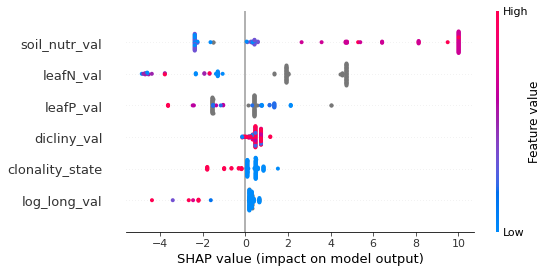

In [30]:
explainer_n = shap.Explainer(model_n)
shap_values_n = explainer_n.shap_values(df_c[indepVar])
shap.summary_plot(shap_values_n, df_c[indepVar])

# note, asks to update to xgboost 1.6 or higher. 

In [31]:
# plot each normalized independent variable vs y normalized
imputed_data = pipeline.named_steps['imputer']
scaled_data = pipeline.named_steps['scaler']

In [32]:
print(imputed_data)
print(scaled_data)

KNNImputer(n_neighbors=3)
StandardScaler()


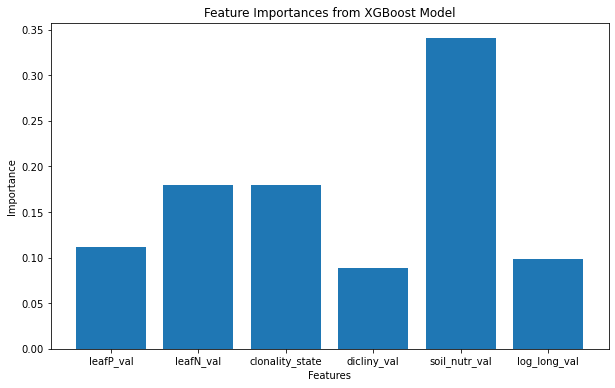

In [33]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(indepVar, model_n.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from XGBoost Model')
plt.show()


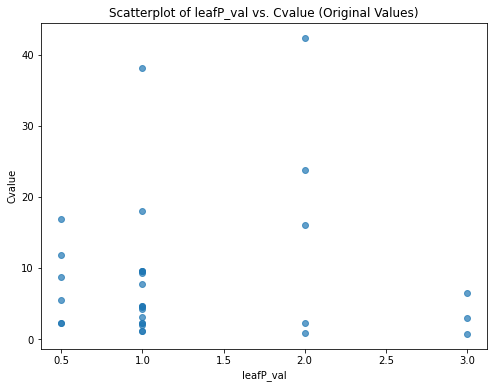

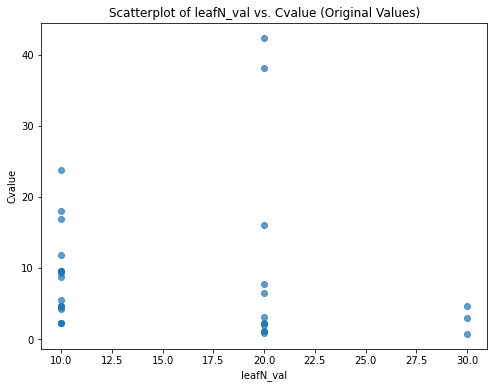

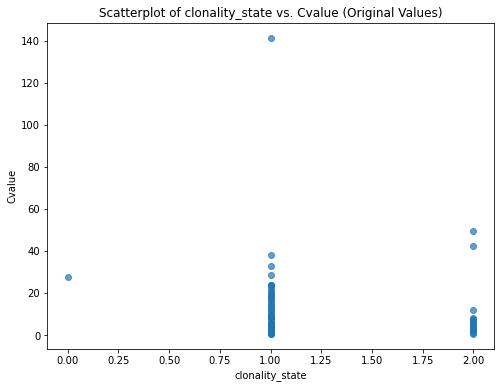

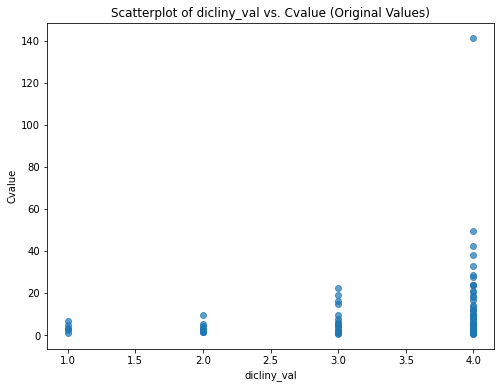

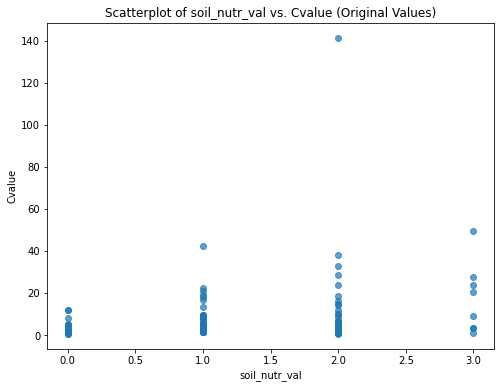

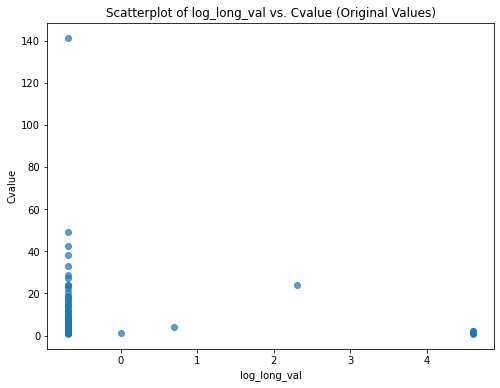

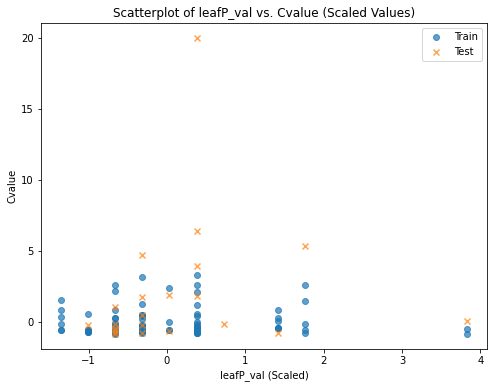

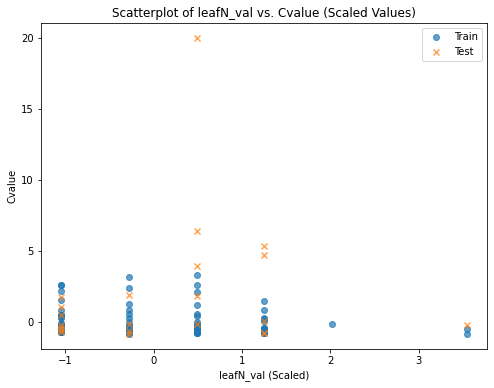

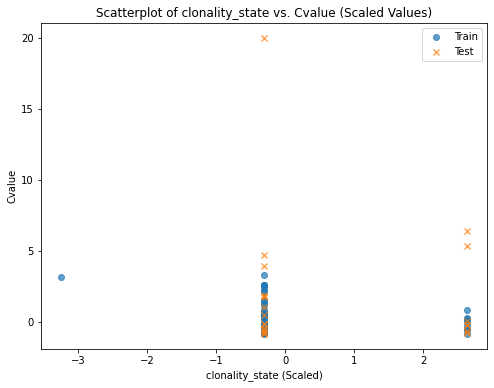

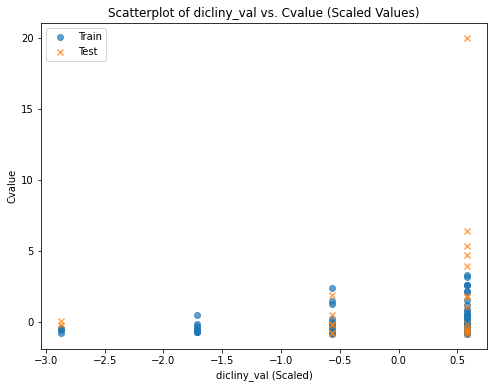

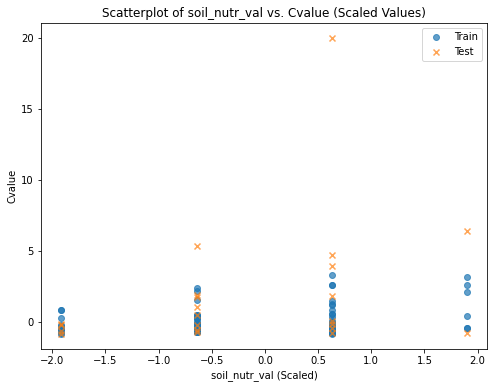

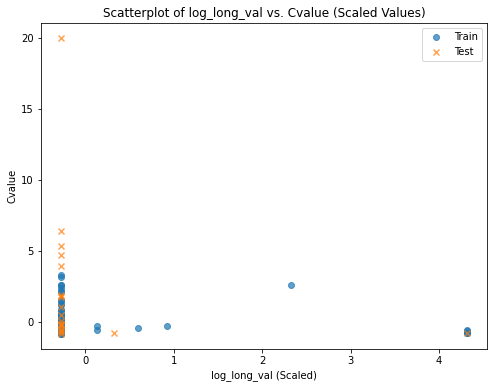

In [35]:
# # Create scatterplots for each independent variable vs. the target variable

# Transform the data using the fitted pipeline (excluding the model step)
X_train_scaled = pipeline.named_steps['scaler'].transform(pipeline.named_steps['imputer'].transform(X_train))
X_test_scaled = pipeline.named_steps['scaler'].transform(pipeline.named_steps['imputer'].transform(X_test))

# Convert scaled arrays to DataFrame for easier plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=indepVar)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=indepVar)

# Convert y_train and y_test to NumPy arrays
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Scale the target variable using StandardScaler
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=['Cvalue'])
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=['Cvalue'])


# Plot scatterplots for each independent variable vs. the target variable (original values)
for var in indepVar:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_c[var], df_c['Cval'], alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Cvalue')
    plt.title(f'Scatterplot of {var} vs. Cvalue (Original Values)')
    plt.show()

# Plot scatterplots for each independent variable vs. the target variable (scaled values)
for var in indepVar:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_scaled_df[var], y_train_scaled_df['Cvalue'], alpha=0.7, label='Train')
    plt.scatter(X_test_scaled_df[var], y_test_scaled_df['Cvalue'], alpha=0.7, label='Test', marker='x')
    plt.xlabel(f'{var} (Scaled)')
    plt.ylabel('Cvalue')
    plt.title(f'Scatterplot of {var} vs. Cvalue (Scaled Values)')
    plt.legend()
    plt.show()


In [37]:
from scipy.stats import zscore

# Calculate Z-scores for the target variable
df_c['Cvalue_zscore'] = zscore(df_c['Cval'])

# Identify outliers (e.g., Z-score > 3 or < -3)
outliers = df_c[np.abs(df_c['Cvalue_zscore']) > 3]
print(outliers)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


       plant_no  long_val  soil_nutr_val  leafP_val  leafN_val  \
506  1830230010       0.5            2.0        NaN        NaN   

     clonality_state  dicliny_val             plant_name        genus  \
506                1          4.0  FRITILLARIA MELEAGRIS  FRITILLARIA   

        family   Cval  No_bugs  log_long_val  Cvalue_zscore  
506  LILIACEAE  141.4      NaN     -0.693147       8.417965  


In [43]:
# Remove outliers from the DataFrame
df_cleaned = df_c[np.abs(df_c['Cvalue_zscore']) <= 3]

# Drop the Z-score column as it's no longer needed
df_cleaned = df_cleaned.drop(columns=['Cvalue_zscore'])


In [44]:
print(df_cleaned['long_val'].head)
print(df_cleaned['log_long_val'].head)

<bound method NDFrame.head of 7      100.0
8      100.0
11     100.0
15       0.5
24       0.5
       ...  
574      0.5
575      0.5
576      2.0
587      1.0
589      NaN
Name: long_val, Length: 108, dtype: float64>
<bound method NDFrame.head of 7      4.605170
8      4.605170
11     4.605170
15    -0.693147
24    -0.693147
         ...   
574   -0.693147
575   -0.693147
576    0.693147
587    0.000000
589         NaN
Name: log_long_val, Length: 108, dtype: float64>


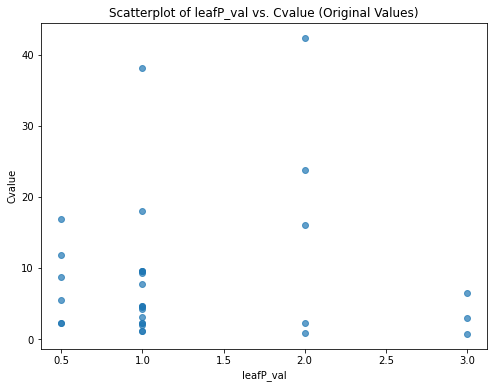

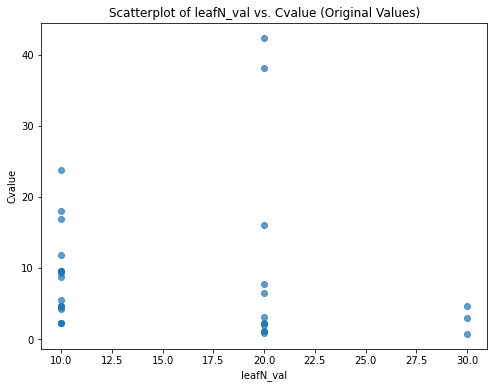

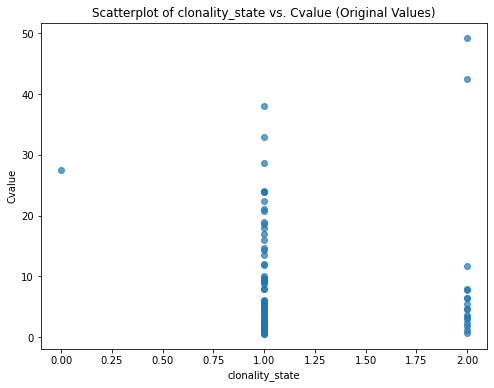

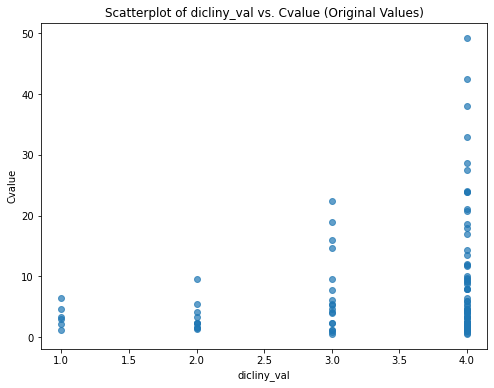

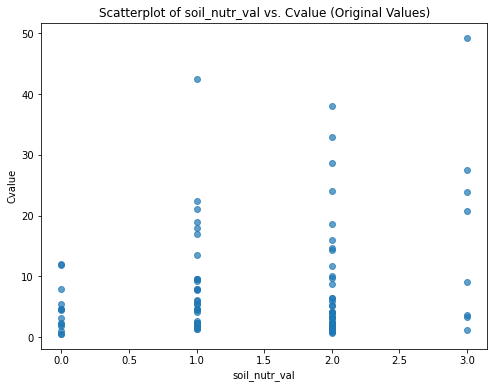

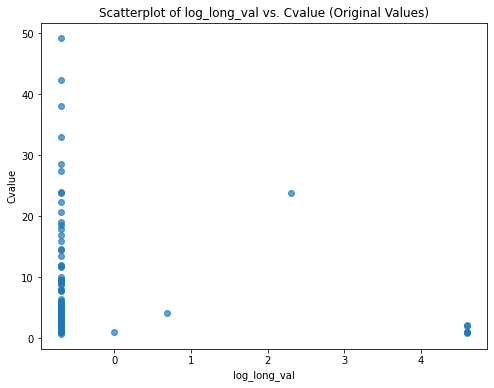

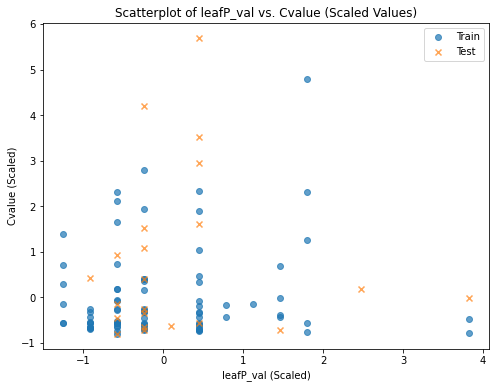

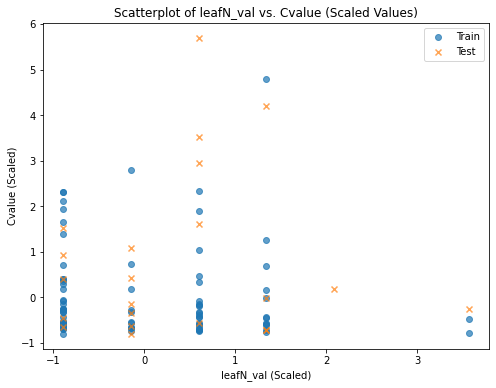

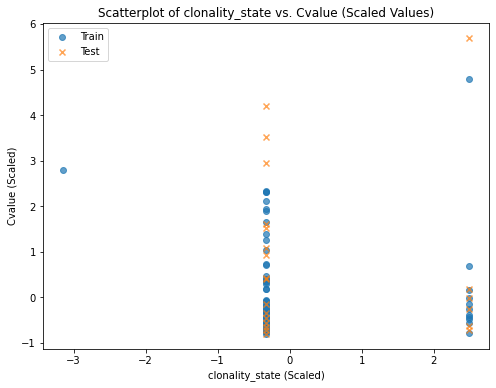

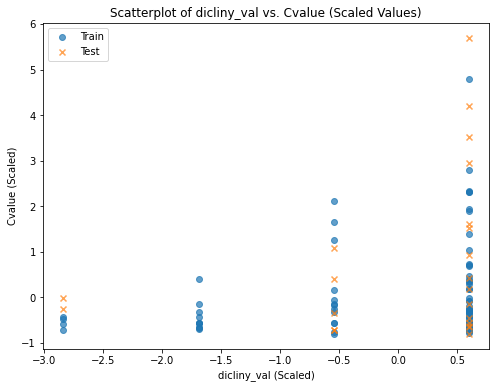

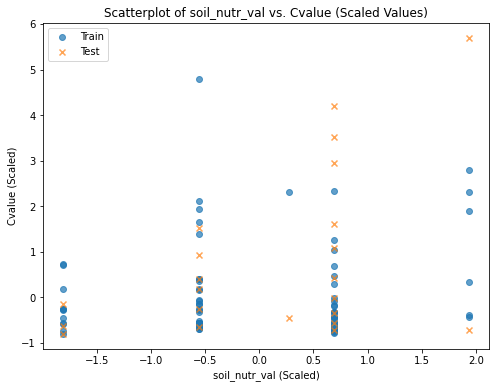

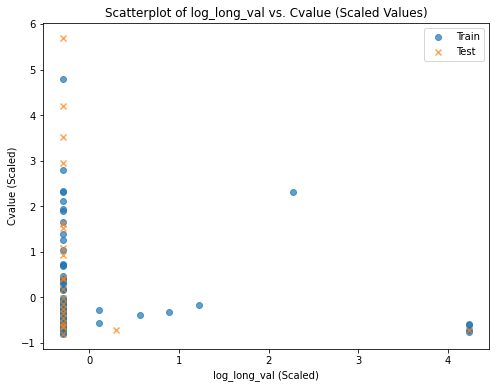

In [47]:

indepVar = ['leafP_val', 'leafN_val', 'clonality_state', 'dicliny_val', 'soil_nutr_val', 'log_long_val']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned[indepVar], df_cleaned['Cval'], test_size=0.2, random_state=42)

# Create a pipeline with KNN imputer and standard scaler for independent variables
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),  # You can adjust the number of neighbors
    ('scaler', StandardScaler()),
    ('model', XGBRegressor())
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Transform the data using the fitted pipeline (excluding the model step)
X_train_scaled = pipeline.named_steps['scaler'].transform(pipeline.named_steps['imputer'].transform(X_train))
X_test_scaled = pipeline.named_steps['scaler'].transform(pipeline.named_steps['imputer'].transform(X_test))

# Convert y_train and y_test to NumPy arrays
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Scale the target variable using StandardScaler
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Convert scaled arrays to DataFrame for easier plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=indepVar)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=indepVar)
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=['Cval'])
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=['Cval'])

# Plot scatterplots for each independent variable vs. the target variable (original values)
for var in indepVar:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_cleaned[var], df_cleaned['Cval'], alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Cvalue')
    plt.title(f'Scatterplot of {var} vs. Cvalue (Original Values)')
    plt.show()

# Plot scatterplots for each independent variable vs. the target variable (scaled values)
for var in indepVar:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_scaled_df[var], y_train_scaled_df['Cval'], alpha=0.7, label='Train')
    plt.scatter(X_test_scaled_df[var], y_test_scaled_df['Cval'], alpha=0.7, label='Test', marker='x')
    plt.xlabel(f'{var} (Scaled)')
    plt.ylabel('Cvalue (Scaled)')
    plt.title(f'Scatterplot of {var} vs. Cvalue (Scaled Values)')
    plt.legend()
    plt.show()


In [48]:

# Extract the model from the pipeline
model_n = pipeline.named_steps['model']
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Cross-validation scores
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation MSE:", -scores.mean())


Mean Squared Error: 242.57646972934543
Cross-validation MSE: 85.98966229333026


In [49]:
# Print feature importances
print("Feature Importances:", model_n.feature_importances_)
print("The features are:", indepVar)

Feature Importances: [0.12107476 0.11364975 0.19149673 0.09850532 0.31836602 0.15690735]
The features are: ['leafP_val', 'leafN_val', 'clonality_state', 'dicliny_val', 'soil_nutr_val', 'log_long_val']


You are using an XGBoost version below 1.6.0 which is not fully supported by shap. Shap falls back to encoding the model as JSON which can lead to numerical precision issues. Please consider upgrading to XGBoost 1.6.0 or higher.


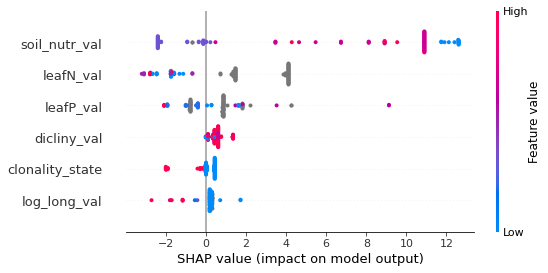

In [50]:
explainer_n = shap.Explainer(model_n)
shap_values_n = explainer_n.shap_values(df_cleaned[indepVar])
shap.summary_plot(shap_values_n, df_cleaned[indepVar])

# note, asks to update to xgboost 1.6 or higher. 

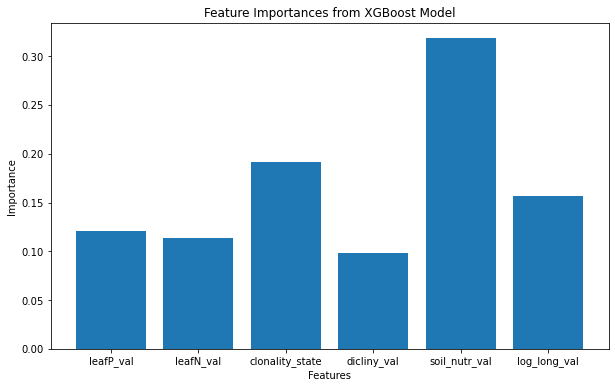

In [51]:
# plot each normalized independent variable vs y normalized
imputed_data = pipeline.named_steps['imputer']
scaled_data = pipeline.named_steps['scaler']
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(indepVar, model_n.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from XGBoost Model')
plt.show()

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
# Predictions
y_pred = model.predict(X_test)

def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - n_features - 1))
    return adj_r2
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = adjusted_r2_score(y_test, y_pred, X_test.shape[1])
explained_variance = explained_variance_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adj_r2}")
print(f"Explained Variance Score: {explained_variance}")
print(f"Mean Absolute Percentage Error: {mape}%")


Mean Squared Error: 224.88621025464684
Root Mean Squared Error: 14.996206528807438
Mean Absolute Error: 10.162403913194483
R-squared: -0.2872972320474416
Adjusted R-squared: -0.8022161248664181
Explained Variance Score: -0.1303415583227454
Mean Absolute Percentage Error: 196.85033405630142%
